# LIM forecasting: multivariate separate sic each month

Katie Brennan  
started May 2021  
  
#### Goals: 
* Build LIM with all months 
* Validate on: different model output, satellite data, historical simulations

In [1]:
import sys,os
import xarray as xr
import numpy as np
import scipy as spy
import pickle 

import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from collections import OrderedDict 

import time as timestamp 

In [2]:
sys.path.append("/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/")
import LIM_utils as lim

import LIM_utils_kb as limkb
import LIM_stats_kb as statskb
import LIM_plot_kb as plotkb
import LIM_building as limbuild

In [3]:
import importlib
importlib.reload(limkb)
importlib.reload(statskb)
importlib.reload(limbuild)

<module 'LIM_building' from '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIM_building.py'>

In [4]:
# %load_ext autoreload
# %autoreload 2

In [5]:
arc_proj = dict(projection=ccrs.Stereographic(central_latitude=90,
                                              central_longitude=-45,
                                              true_scale_latitude=0.1))
proj = dict(projection=ccrs.Robinson(central_longitude=0.),zorder=1)

In [6]:
month_names = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec']

In [8]:
# number of EOFs to retain for the LIM state vector
ntrunc = 400 # EOF truncation for individual fields (reduced-state space)
nmodes = 60 # number of coupled EOFs for LIM state space (truncated-state space)
#nmodes = 25
nmodes_sic = 50
#modes_sic = 20

mo='all'
#mo=0

# forecast lead time in months that defines the LIM training
tau = 1

# training data defined by the first ntrain times
# fraction of years used in training
# ensures that start year of both train and validation data is january 
ntrain = 0.3
nvalidtimes = 600

# variables to include in the LIM (note "vars" is a Python command)
#limvars = ['tas','zg']
#limvars = ['tas','rlut','zg']
#limvars = ['sic']
#limvars = ['tas','sic']
#limvars = ['tas','sic','zg','psl','pr','tos']
#limvars = ['tas','psl','tos','sit','sic']
# limvars = ['tas','tos','psl','sit','sic']
# limvars_nosic = ['tas','tos','psl','sit']
limvars = ['tas','tos','sit','sic']
limvars_nosic = ['tas','tos']
nvars = len(limvars)

# specify the model source 
train_dsource = 'mpi_lm_kb'
#train_dsource = 'ccsm4_lm_kb'
valid_dsource = 'mpi_hist_kb'
#valid_dsource = 'ccsm4_lm_kb'

sic_separate = True
Insamp = False

In [9]:
from datetime import date

today = date.today()

#Year-month-day
today_date = today.strftime("%Y%m%d")

In [10]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
pi = np.pi

# fill continents if plotting SST; otherwise no
# if var_to_extract == 'tos':
#     noland = True
# else:
#     noland = False

infile_20cr_tas = '/home/disk/kalman3/rtardif/LMR/data/model/20cr/tas_sfc_Amon_20CR_185101-201112.nc'

fdic_train = limkb.build_training_dic(train_dsource)
fdic_valid = limkb.build_training_dic(valid_dsource)

full_names, areawt_name, month_names = limbuild.load_full_names()
areacell, areacell_dict = limbuild.load_areacell_dict(fdic_train, remove_climo=False, 
                                                      detrend=False, verbose=False )

## Build L from scratch: 

In [12]:
## Start with full training data: 
# [Ptrunc, Ptrunc_valid, E3, tot_var, 
#  tot_var_eig, W_all,standard_factor, nyears_train, 
#  var_dict] = limbuild.load_training_valid_data_full(limvars, fdic_train, mo, areacell, ntrain, 
#                                                     areawt_name, ntrunc, nmodes_sic, 
#                                                     sic_separate=sic_separate,
#                                                     remove_climo=True,detrend=True, 
#                                                     wt=True, verbose=True)

# Start with truncated training data: 
mod_folder = 'truncated_model_data/'
mod_filename = '_ntrunc400_mpi_lm_kb_20210406.pkl'
mod_sic_filename = '_ntrunc50_mpi_lm_kb_20210406.pkl'

[Ptrunc, Ptrunc_valid, E3, tot_var, 
 tot_var_eig, W_all, standard_factor, 
 nyears_train, var_dict] = limbuild.load_training_data_truncated(limvars, mod_folder, mod_sic_filename, 
                                                                 mod_filename, mo, ntrain)

var_dict = limbuild.get_var_incices(limvars, var_dict)

Loading truncated tas


FileNotFoundError: [Errno 2] No such file or directory: 'truncated_model_data/tas_ntrunc400_mpi_lm_kb_20210406.pkl'

In [12]:
limvars_nosic = [l for l in limvars if l not in 'sic']
nvars = len(limvars_nosic)
nvars, limvars, limvars_nosic

(3, ['tas', 'tos', 'sit', 'sic'], ['tas', 'tos', 'sit'])

In [13]:
ndof_all = limkb.count_ndof_all(limvars, E3, sic_separate=sic_separate)

[Ptrunc_all, E3_all, 
Ptrunc_sic,E_sic] = limkb.stack_variable_eofs(limvars, ndof_all, ntrunc, Ptrunc, E3, 
                                              var_dict, sic_separate=sic_separate)

[P_train, Fvar, E] = limkb.step2_multivariate_compress(Ptrunc_all, nmodes, E3_all, Ptrunc_sic, 
                                                       sic_separate=sic_separate, Trunc_truth=False)

# [Ptrunc_all, E3_all] = limkb.stack_variable_eofs(limvars, ndof_all, ntrunc, Ptrunc, E3, 
#                                                  var_dict, sic_separate=sic_separate)

# [P_train, Fvar, E] = limkb.step2_multivariate_compress(Ptrunc_all,nmodes, E3_all, 0, 
#                                                        sic_separate=sic_separate, Trunc_truth=False)

0, tas
1, tos
2, sit
Fraction in first 60 multivariate EOFs = 68.28813094517018
Shape of E: (131072, 60)


In [14]:
ndof_all_valid = limkb.count_ndof_all(limvars, E3, sic_separate=sic_separate)

[Ptrunc_all_valid, E3_all_valid,
 Ptrunc_sic_valid, E_sic_valid] = limkb.stack_variable_eofs(limvars, ndof_all_valid, ntrunc, Ptrunc_valid,
                                                            E3, var_dict, sic_separate=sic_separate)

[P_train_valid, Fvar_valid, 
 E_valid] = limkb.step2_multivariate_compress(Ptrunc_all_valid,nmodes, E3_all_valid, Ptrunc_sic_valid,
                                              sic_separate=sic_separate, Trunc_truth=False)

0, tas
1, tos
2, sit
Fraction in first 60 multivariate EOFs = 67.83778877882612
Shape of E: (131072, 60)


In [16]:
nmo = int(P_train.shape[1]/nyears_train)
P_train_3d = np.reshape(P_train, (P_train.shape[0],nyears_train,nmo))

if mo is 'all':
    LIMd2, G2 = lim.LIM_train(tau,P_train)
    print('Training LIM with tau = '+str(tau))
else: 
    LIMd2, G2 = lim.LIM_train_flex(tau,P_train_3d[:,:,0], P_train_3d[:,:,1])
    print('Training LIM with tau = '+str(tau))

Training LIM with tau = 1


In [17]:
max_eigenval = np.real(LIMd2['lam_L']).max()

if max_eigenval >0: 
    LIMd2['lam_L_adj'] = LIMd2['lam_L'] - (max_eigenval+0.01)
else: 
    LIMd2['lam_L_adj'] = LIMd2['lam_L']

In [18]:
#LIMd2['lam_L']

In [19]:
#LIMd2['lam_L_adj']

In [20]:
(LIMd2['lam_L']>0).sum()/(LIMd2['lam_L'].shape[0])

0.0

In [ ]:
plt.plot(P_train_3d[0,:,0])
plt.plot(P_train_3d[0,:,1])

## Run Forecast: 

In [ ]:
P_train[:,0:nyears_train].shape, nyears_train*.3, P_train_valid[:,0:4000].shape

In [21]:
# LIM forecasts for a range of monthly values (can specify a list of arbitrary values too)
lags = [0,1,2,3,4,5,6,7,8,9,10,11]
#lags = [0,1,2,3]
ntims = len(lags)
adj = True

nyr_train = nyears_train

if mo == 'all':
    if Insamp==True: 
        print('Performing in sample forecast')
        LIM_fcast = limkb.LIM_forecast(LIMd2,P_train[:,0:nyr_train],lags,adjust=adj)
    else: 
        print('Performing out of sample forecast')
        LIM_fcast = limkb.LIM_forecast(LIMd2,P_train_valid[:,0:nvalidtimes],lags,adjust=adj)
else: 
    if Insamp==True: 
        print('Performing in sample forecast')
        P_train_2d = np.reshape(P_train, (P_train.shape[0],int(P_train.shape[1]/2),2))
        LIM_fcast = limkb.LIM_forecast(LIMd2,P_train_2d[:,:,0],lags,adjust=adj)
    else: 
        print('Performing out of sample forecast')
        LIM_fcast = limkb.LIM_forecast(LIMd2,P_train_valid,lags,adjust=adj)
    
#LIM_fcast = LIM_forecast_Gt(LIMd2,P_train_valid,lags)

Performing out of sample forecast
Adjust is True...
NO negative eigenvalue found...
t= 0
t= 1
t= 2
t= 3
t= 4
t= 5
t= 6
t= 7
t= 8
t= 9
t= 10
t= 11


## Decompress forecast and validate:

In [22]:
x_forecast_dcomp = np.zeros((len(lags),E.shape[0]+E_sic.shape[0],LIM_fcast['x_forecast'].shape[2]))

for i,lag in enumerate(lags):
    print('Lag '+ str(lag))
    x_forecast_dcomp[i,:,:] = limkb.decompress_eof_separate_sic(LIM_fcast['x_forecast'][i,:,:],
                                                                nmodes,nmodes_sic,E,
                                                                E_sic,limvars,var_dict,
                                                                W_all,Weights=True,
                                                                sic_separate=sic_separate)

Lag 0
Lag 1
Lag 2
Lag 3
Lag 4
Lag 5
Lag 6
Lag 7
Lag 8
Lag 9
Lag 10
Lag 11


#### Validate all variables: 

In [ ]:
validvars = ['tas','tos','sic']
v = {}
validation_stats = {}
lags_test = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
#lags_test = [0, 1]
gm_variance_mo = {}
valid_stats_allmo = {}

for k, var in enumerate(validvars):
    X_var, _ = limkb.load_data(var, v, fdic_train, remove_climo=True, detrend=True, verbose=True)
    
    var_3d = np.reshape(X_var,(X_var.shape[0],1000,12))
    x_anom_var = np.nanvar(var_3d,axis=1,ddof=1)
    gm_x_var = statskb.global_mean(x_anom_var,areacell[areawt_name[var]])
    
    gm_variance_mo[var] = gm_x_var
    
    corr_tot = np.zeros((len(lags)))
    ce_tot = np.zeros((len(lags)))
    gm_var_ratio = np.zeros((len(lags)))
    valid_stats = {}

    for i,lag in enumerate(lags_test):
        print('Lag '+str(lag))
        [truth_anom, forecast_anom] = limbuild.gather_truth_forecast(lag,var,mo,X_var,x_forecast_dcomp,
                                                                     nvalidtimes,var_dict,ntrain,
                                                                     insamp=Insamp)
        print('Truth_anom shape: '+str(truth_anom.shape))
        print('Forecast_anom shape: '+str(forecast_anom.shape))

        [corr_tot[i], ce_tot[i], gm_var_ratio[i], tot_var_forecast, 
         tot_var_truth] = limbuild.calc_validataion_stats(var, truth_anom, forecast_anom, var_dict,
                                                          areacell,areacell_dict,
                                                          areawt_name,month_names,iplot=True)
        
    valid_stats['corr_tot'] = corr_tot
    valid_stats['ce_tot'] = ce_tot
    valid_stats['gm_var_ratio'] = gm_var_ratio
    
    validation_stats[var] = valid_stats
    
valid_stats_allmo[mo] = validation_stats

#### Variance across variables across months:

In [ ]:
for var in validvars:
    plt.plot(gm_variance_mo[var], label=var)
    
plt.title('Global mean variance in LM simulation')
plt.ylabel('Variance (%$^2$)')
plt.xticks(np.arange(0,12,1),month_names, rotation=45)
plt.legend()

In [ ]:
for var in validvars:
    plt.plot(gm_variance_mo[var]/gm_variance_mo[var].max(), label=var)
    
plt.title('Global mean variance in LM simulation')
plt.ylabel('Variance (%$^2$)')
plt.xticks(np.arange(0,12,1),month_names, rotation=45)
plt.legend()

#### Validate single variable: 

In [ ]:
lags_test = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
validvars = ['sic']
v = {}
validation_stats_test = {}

for k, var in enumerate(validvars):
    X_var, _ = limkb.load_data(var, v, fdic_train, remove_climo=True, detrend=True, verbose=True)
    
    corr_tot = np.zeros((len(lags)))
    ce_tot = np.zeros((len(lags)))
    gm_var_ratio = np.zeros((len(lags)))
    valid_stats_test = {}

    for i,lag in enumerate(lags_test):
        print('Lag '+str(lag))
        [truth_anom, forecast_anom] = limbuild.gather_truth_forecast(lag,var,mo,X_var,x_forecast_dcomp,
                                                                     var_dict,ntrain,insamp=Insamp)
        print('Truth_anom shape: '+str(truth_anom.shape))
        print('Forecast_anom shape: '+str(forecast_anom.shape))
        
#         if lag == 1: 
#             truth_error_var = np.nanvar(truth_anom,axis=1,ddof=1)
#             truth_error_var = np.where(truth_var<1,0,truth_var)
#             gm_truth_var = statskb.global_mean(truth_error_var,areacell[areawt_name[var]])          
    
#         error_var = np.nanvar(truth_anom-forecast_anom,axis=1,ddof=1)
#         truth_error_var = np.nanvar(truth_anom,axis=1,ddof=1)

#         ratio = error_var/truth_error_var
        
#         area_shape = areacell[areawt_name[var]].shape
#         gm_var_ratio[i] = statskb.global_mean(ratio[np.isfinite(ratio)],
#                                               np.reshape(areacell[areawt_name[var]],(area_shape[0]*area_shape[1]))[np.isfinite(ratio)])

        if lag ==1: 
            truth_error_var = np.nanvar(truth_anom,axis=1,ddof=1)
            area_shape = areacell[areawt_name[var]].shape
            gm_truth_var = statskb.global_mean(truth_error_var[truth_error_var>0],
                                               np.reshape(areacell[areawt_name[var]],(area_shape[0]*area_shape[1]))[truth_error_var>0])

        area_shape = areacell[areawt_name[var]].shape
        error_var = np.nanvar(truth_anom-forecast_anom,axis=1,ddof=1)
        gm_error_var = statskb.global_mean(error_var[truth_error_var>0],
                                           np.reshape(areacell[areawt_name[var]],(area_shape[0]*area_shape[1]))[truth_error_var>0])

        gm_var_ratio[i]=gm_error_var/gm_truth_var
#         print(gm_error_var)
#         print(gm_truth_var)
        
    valid_stats_test['gm_var_ratio'] = gm_var_ratio
    validation_stats_test[var] = valid_stats_test

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(7,4))
#fig,axs= plt.subplots(2, 2)

#ax = axs.flatten()

for i,var in enumerate(['sic']):
    ax.plot(np.arange(1,13,1),validation_stats_test[var]['gm_var_ratio'])

#    ax[i].set_ylim(0,1)
    ax.set_xlim(1,10)
#    ax.set_ylim(0,1.1)
    ax.set_xticks([1,2,3,4,5,6,7,8,9,10])
    ax.grid(axis='both')
    ax.set_ylabel('GM ratio: \nerror variance to true variance', fontsize=14)
    ax.set_title(var, fontsize=16)
if mo == 'all':
    plt.suptitle('All months', fontsize=16)
else: 
    plt.suptitle(month_names[mo], fontsize=16)
    
ax.set_xlabel('lead time (months)', fontsize=14)
ax.set_xlabel('lead time (months)', fontsize=14)

#### Validate SIC: 

In [ ]:
# validvars = ['sic']
# v = {}
# validation_stats = {}

# for k, var in enumerate(validvars):
#     X_var, _ = limkb.load_data(var, v, fdic_train, remove_climo=True, detrend=True, verbose=True)
    
#     corr_tot = np.zeros((len(lags)))
#     ce_tot = np.zeros((len(lags)))
#     gm_var_ratio = np.zeros((len(lags)))
#     valid_stats = {}

#     for i,lag in enumerate(lags):
#         print('Lag '+str(lag))
#         [truth_anom, forecast_anom] = limbuild.gather_truth_forecast(lag,var,mo,X_var,x_forecast_dcomp,
#                                                                      var_dict,ntrain,insamp=Insamp)
#         print(truth_anom.shape)
#         print(forecast_anom.shape)

#         [corr_tot[i], ce_tot[i], gm_var_ratio[i], tot_nh_sic_forecast, 
#          tot_nh_sic_truth] = limbuild.calc_validataion_stats(var, truth_anom, forecast_anom, var_dict,
#                                                              areacell,areacell_dict,
#                                                              areawt_name,month_names,iplot=True)
        
#     valid_stats['corr_tot'] = corr_tot
#     valid_stats['ce_tot'] = ce_tot
#     valid_stats['gm_var_ratio'] = gm_var_ratio
    
#     validation_stats[var] = valid_stats
    
# valid_stats_allmo[mo] = validation_stats

In [ ]:
# valid_stats['corr_tot'] = corr_tot
# valid_stats['ce_tot'] = ce_tot
# valid_stats['gm_var_ratio'] = gm_var_ratio

# validation_stats[var] = valid_stats

# valid_stats_allmo[mo] = validation_stats

### All limvar plots: 

In [ ]:
mo

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(15,9))
#fig,axs= plt.subplots(2, 2)

ax = axs.flatten()

for i,var in enumerate(limvars):
    ax[i].plot(validation_stats[var]['corr_tot']**2, label='Correlation')
    ax[i].plot(validation_stats[var]['ce_tot'],label='CE')

    ax[i].set_ylim(0,1)
    ax[i].set_xlim(0,10)
    ax[i].set_xticks([0,1,2,3,4,5,6,7,8,9,10])
    ax[i].grid(axis='both')
    ax[i].set_title(var, fontsize=14)
if mo == 'all':
    plt.suptitle('All months', fontsize=16)
else: 
    plt.suptitle(month_names[mo], fontsize=16)
ax[0].legend(loc='upper right')
ax[2].set_xlabel('lead time (months)', fontsize=14)
ax[3].set_xlabel('lead time (months)', fontsize=14)

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(15,9))
#fig,axs= plt.subplots(2, 2)

ax = axs.flatten()

for i,var in enumerate(limvars):
    ax[i].plot(validation_stats[var]['gm_var_ratio'])

#    ax[i].set_ylim(0,1)
    ax[i].set_xlim(0,10)
    ax[i].set_ylim(0,1.2)
    ax[i].set_xticks([0,1,2,3,4,5,6,7,8,9,10])
    ax[i].grid(axis='both')
    ax[i].set_ylabel('GM ratio: \nerror variance to true variance', fontsize=14)
    ax[i].set_title(var, fontsize=16)
if mo == 'all':
    plt.suptitle('All months', fontsize=16)
else: 
    plt.suptitle(month_names[mo], fontsize=16)
    
ax[2].set_xlabel('lead time (months)', fontsize=14)
ax[3].set_xlabel('lead time (months)', fontsize=14)

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(15,9))
#fig,axs= plt.subplots(2, 2)

ax = axs.flatten()

for i,var in enumerate(limvars):
    ax[i].plot(validation_stats_test[var]['gm_var_ratio'])

#    ax[i].set_ylim(0,1)
    ax[i].set_xlim(0,11)
    ax[i].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
    ax[i].grid(axis='both')
    ax[i].set_ylabel('GM ratio: \nerror variance to true variance (1 lag only)', fontsize=14)
    ax[i].set_title(var, fontsize=16)
if mo == 'all':
    plt.suptitle('All months', fontsize=16)
else: 
    plt.suptitle(month_names[mo], fontsize=16)
    
ax[2].set_xlabel('lead time (months)', fontsize=14)
ax[3].set_xlabel('lead time (months)', fontsize=14)

### Validation plots: 

In [ ]:
plt.plot(valid_stats['corr_tot']**2, label='Correlation')
plt.plot(valid_stats['ce_tot'],label='CE')
#plt.axhline(0,linestyle='--', color='k')
plt.ylim(0,1)
plt.xlim(0,4)
plt.xticks([0,1,2,3])
plt.grid(axis='both')
plt.xlabel('lead time (months)')
if mo == 'all':
    plt.title('All months')
else: 
    plt.title(month_names[mo])
plt.legend(loc='lower right')

In [ ]:
valid_stats['corr_tot']**2

In [ ]:
plt.plot(valid_stats['gm_var_ratio'])
plt.axhline(1,linestyle='--', color='k')
plt.xticks([0,1,2,3])
plt.ylim(0,1.1)
plt.xlabel('lead time (months)')
if mo == 'all':
    plt.title('All months')
else: 
    plt.title(month_names[mo])
plt.ylabel('GM ratio: error variance to true variance')

In [ ]:

plt.plot(tot_nh_sic_forecast*1e-6, label='forecast')
plt.plot((tot_nh_sic_truth-np.mean(tot_nh_sic_truth,axis=0))*1e-6, label='truth')
#plt.plot(tot_nh_sic_forecast[3:]*1e-6, label='forecast')
plt.xlim(0,50)
#plt.ylim(-20,20)
plt.legend()

## All months: 

In [ ]:
import pyLIM_1monthLIM_1monthforecast_allmo_042321 as runexp

In [ ]:
# import importlib
# importlib.reload(runexp)
# importlib.reload(limbuild)

In [ ]:
valid_stats_allmo = runexp.run_forecast()

In [ ]:
(valid_stats_allmo.keys())

In [ ]:
valid_stats_1mo = {}

for var in limvars:
    print('Working on '+str(var)+'...')
    corr_plot = np.zeros((11))
    ce_plot = np.zeros((11))
    gm_var_ratio = np.zeros((11))
    v = {}

    for m in range(11):
        corr_plot[m] = valid_stats_allmo[m][var]['corr_tot'][1]**2
        ce_plot[m] = valid_stats_allmo[m][var]['ce_tot'][1]
        gm_var_ratio[m] = valid_stats_allmo[m][var]['gm_var_ratio'][1]

    v['corr2_plot'] = corr_plot
    v['ce_plot'] = ce_plot
    v['gm_var_ratio'] = gm_var_ratio
    valid_stats_1mo[var] = v

In [ ]:
limvars = ['tas','tos','sic']

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(15,9))
#fig,axs= plt.subplots(2, 2)

ax = axs.flatten()

for i,var in enumerate(limvars):
    ax[i].plot(valid_stats_1mo[var]['gm_var_ratio'])

#    ax[i].set_ylim(0,1)
#    ax[i].set_xlim(0,10)
    ax[i].set_ylim(0,1.01)
    ax[i].set_xticks(np.arange(0,12,1))
    ax[i].set_xticklabels(month_names,fontsize=12)
    ax[i].grid(axis='both')
    ax[i].set_ylabel('GM ratio: \nerror variance to true variance', fontsize=14)
    ax[i].set_title(var, fontsize=16)

plt.suptitle('All months separate LIM: 1 month lag', fontsize=16)    
ax[2].set_xlabel('Training month', fontsize=14)
ax[3].set_xlabel('Training month', fontsize=14)

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(15,9))
#fig,axs= plt.subplots(2, 2)

ax = axs.flatten()

for i,var in enumerate(limvars):
    ax[i].plot(valid_stats_1mo[var]['corr2_plot'], label='Correlation')
    ax[i].plot(valid_stats_1mo[var]['ce_plot'], label='CE')

#    ax[i].set_ylim(0,1)
#    ax[i].set_xlim(0,10)
    ax[i].set_ylim(0,1.01)
    ax[i].set_xticks(np.arange(0,12,1))
    ax[i].set_xticklabels(month_names,fontsize=12)
    ax[i].grid(axis='both')
    ax[i].set_title(var, fontsize=16)

plt.suptitle('All months separate LIM: 1 month lag', fontsize=16)    
ax[2].set_xlabel('Training month', fontsize=14)
ax[3].set_xlabel('Training month', fontsize=14)
ax[0].legend()

In [24]:
12*167

2004

### All months: break up my month

In [23]:
x_forecast_dcomp_mo = np.reshape(x_forecast_dcomp, (x_forecast_dcomp.shape[0], x_forecast_dcomp.shape[1], 
                                                    int(x_forecast_dcomp.shape[2]/12),12))

x_forecast_dcomp_mo.shape

(12, 187392, 50, 12)

Loading tas
removing climotology...
detrending...
(18432, 12000)
(18432, 12000)
-----------------------------------------------------
completed in 30.949533462524414 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (18432, 50)
Forecast_anom shape: (18432, 50)


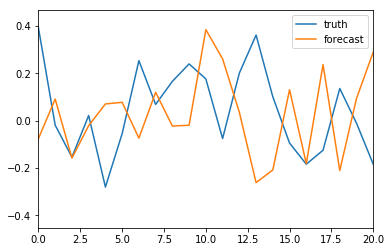

Month 1
Trained using month 1...
Validating against month 1
Truth_anom shape: (18432, 50)
Forecast_anom shape: (18432, 50)


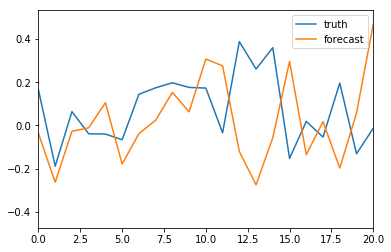

Month 2
Trained using month 2...
Validating against month 2
Truth_anom shape: (18432, 50)
Forecast_anom shape: (18432, 50)


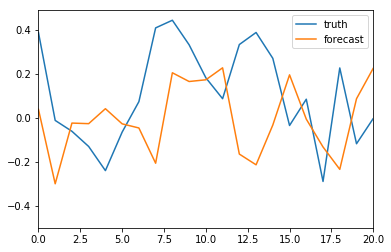

Month 3
Trained using month 3...
Validating against month 3
Truth_anom shape: (18432, 50)
Forecast_anom shape: (18432, 50)


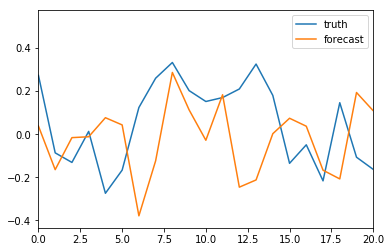

Month 4
Trained using month 4...
Validating against month 4
Truth_anom shape: (18432, 50)
Forecast_anom shape: (18432, 50)


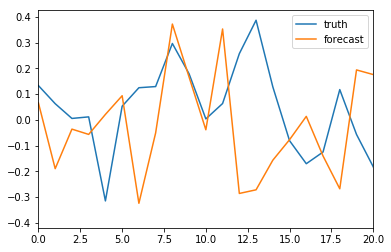

Month 5
Trained using month 5...
Validating against month 5
Truth_anom shape: (18432, 50)
Forecast_anom shape: (18432, 50)


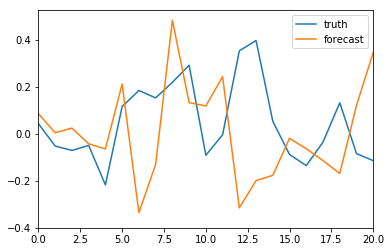

Month 6
Trained using month 6...
Validating against month 6
Truth_anom shape: (18432, 50)
Forecast_anom shape: (18432, 50)


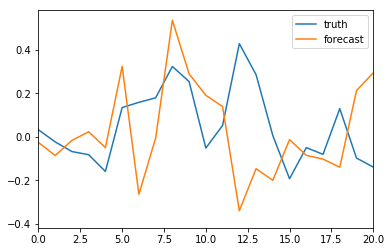

Month 7
Trained using month 7...
Validating against month 7
Truth_anom shape: (18432, 50)
Forecast_anom shape: (18432, 50)


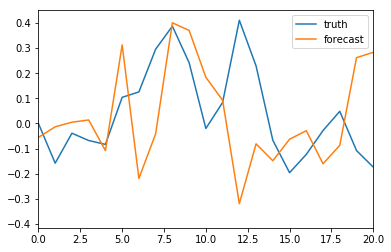

Month 8
Trained using month 8...
Validating against month 8
Truth_anom shape: (18432, 50)
Forecast_anom shape: (18432, 50)


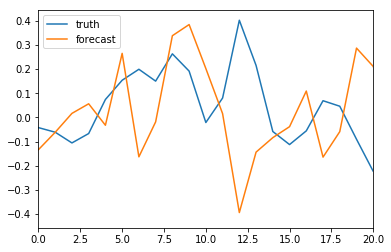

Month 9
Trained using month 9...
Validating against month 9
Truth_anom shape: (18432, 50)
Forecast_anom shape: (18432, 50)


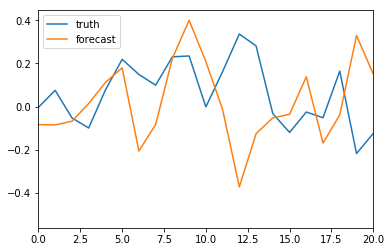

Month 10
Trained using month 10...
Validating against month 10
Truth_anom shape: (18432, 50)
Forecast_anom shape: (18432, 50)


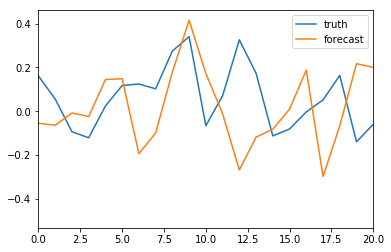

Loading tos
removing climotology...
detrending...
(56320, 12000)
(56320, 12000)
-----------------------------------------------------
completed in 107.9488513469696 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (56320, 50)
Forecast_anom shape: (56320, 50)


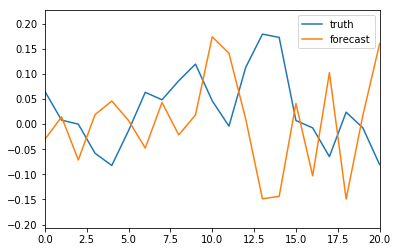

Month 1
Trained using month 1...
Validating against month 1
Truth_anom shape: (56320, 50)
Forecast_anom shape: (56320, 50)


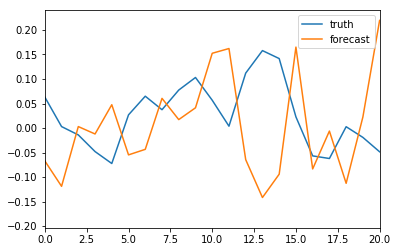

Month 2
Trained using month 2...
Validating against month 2
Truth_anom shape: (56320, 50)
Forecast_anom shape: (56320, 50)


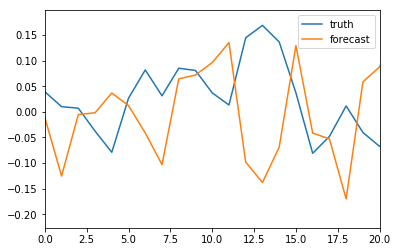

Month 3
Trained using month 3...
Validating against month 3
Truth_anom shape: (56320, 50)
Forecast_anom shape: (56320, 50)


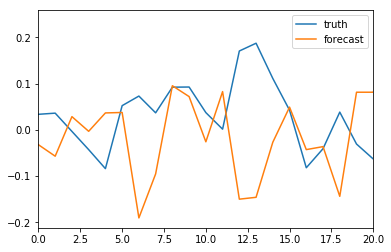

Month 4
Trained using month 4...
Validating against month 4
Truth_anom shape: (56320, 50)
Forecast_anom shape: (56320, 50)


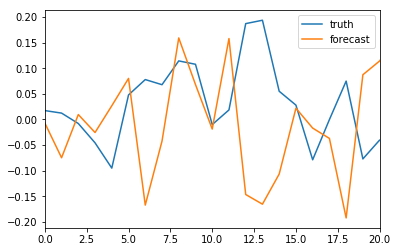

Month 5
Trained using month 5...
Validating against month 5
Truth_anom shape: (56320, 50)
Forecast_anom shape: (56320, 50)


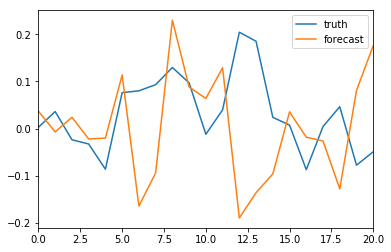

Month 6
Trained using month 6...
Validating against month 6
Truth_anom shape: (56320, 50)
Forecast_anom shape: (56320, 50)


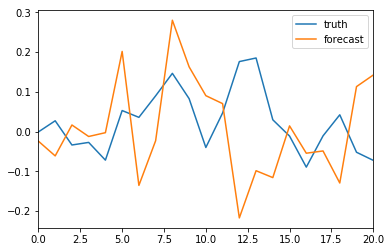

Month 7
Trained using month 7...
Validating against month 7
Truth_anom shape: (56320, 50)
Forecast_anom shape: (56320, 50)


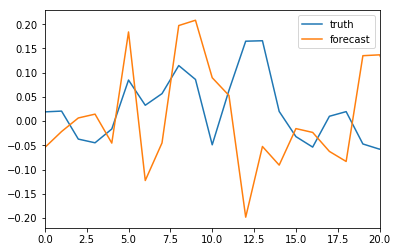

Month 8
Trained using month 8...
Validating against month 8
Truth_anom shape: (56320, 50)
Forecast_anom shape: (56320, 50)


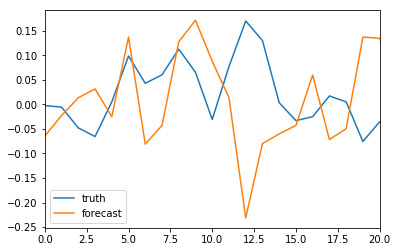

Month 9
Trained using month 9...
Validating against month 9
Truth_anom shape: (56320, 50)
Forecast_anom shape: (56320, 50)


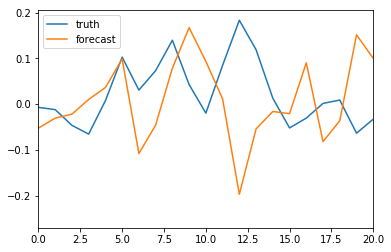

Month 10
Trained using month 10...
Validating against month 10
Truth_anom shape: (56320, 50)
Forecast_anom shape: (56320, 50)


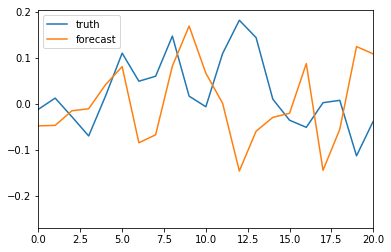

Loading sit
removing climotology...
detrending...
(56320, 12000)
(56320, 12000)
-----------------------------------------------------
completed in 122.51631164550781 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (56320, 50)
Forecast_anom shape: (56320, 50)


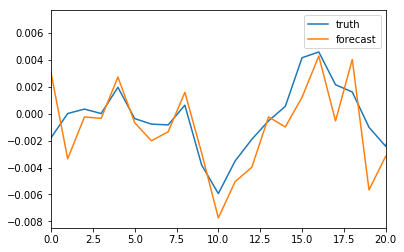

Month 1
Trained using month 1...
Validating against month 1
Truth_anom shape: (56320, 50)
Forecast_anom shape: (56320, 50)


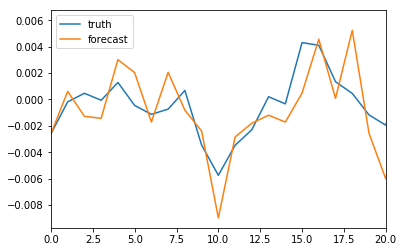

Month 2
Trained using month 2...
Validating against month 2
Truth_anom shape: (56320, 50)
Forecast_anom shape: (56320, 50)


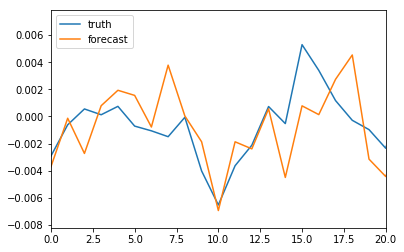

Month 3
Trained using month 3...
Validating against month 3
Truth_anom shape: (56320, 50)
Forecast_anom shape: (56320, 50)


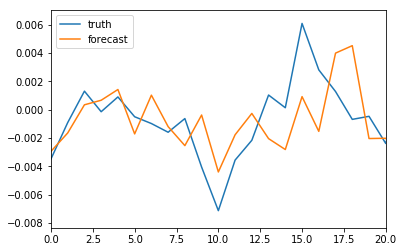

Month 4
Trained using month 4...
Validating against month 4
Truth_anom shape: (56320, 50)
Forecast_anom shape: (56320, 50)


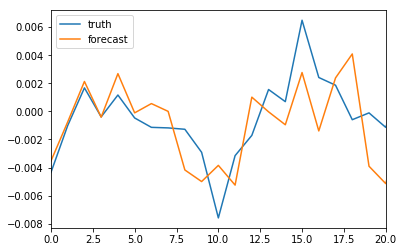

Month 5
Trained using month 5...
Validating against month 5
Truth_anom shape: (56320, 50)
Forecast_anom shape: (56320, 50)


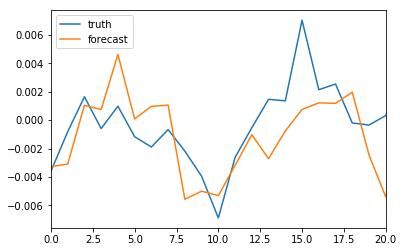

Month 6
Trained using month 6...
Validating against month 6
Truth_anom shape: (56320, 50)
Forecast_anom shape: (56320, 50)


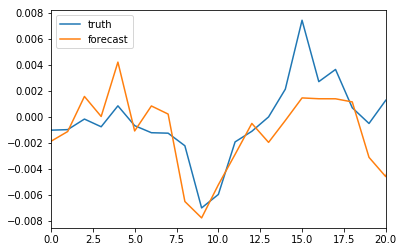

Month 7
Trained using month 7...
Validating against month 7
Truth_anom shape: (56320, 50)
Forecast_anom shape: (56320, 50)


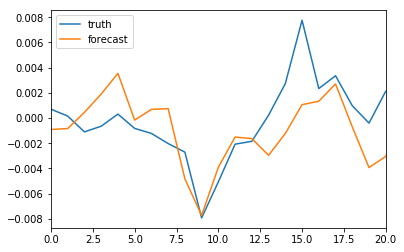

Month 8
Trained using month 8...
Validating against month 8
Truth_anom shape: (56320, 50)
Forecast_anom shape: (56320, 50)


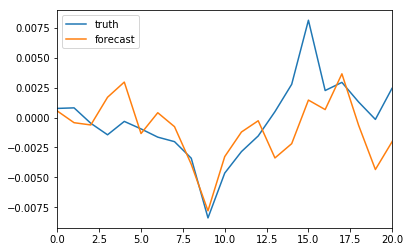

Month 9
Trained using month 9...
Validating against month 9
Truth_anom shape: (56320, 50)
Forecast_anom shape: (56320, 50)


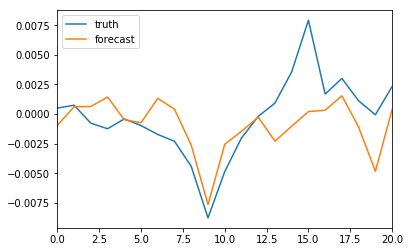

Month 10
Trained using month 10...
Validating against month 10
Truth_anom shape: (56320, 50)
Forecast_anom shape: (56320, 50)


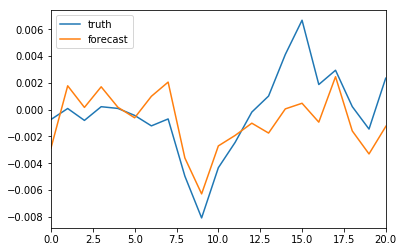

Loading sic
removing climotology...
detrending...
(56320, 12000)
(56320, 12000)
-----------------------------------------------------
completed in 117.75274705886841 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (56320, 50)
Forecast_anom shape: (56320, 50)


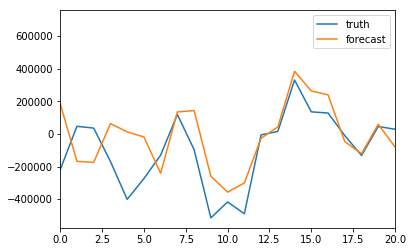

Month 1
Trained using month 1...
Validating against month 1
Truth_anom shape: (56320, 50)
Forecast_anom shape: (56320, 50)


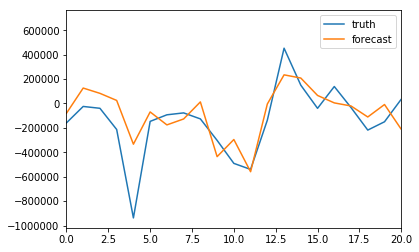

Month 2
Trained using month 2...
Validating against month 2
Truth_anom shape: (56320, 50)
Forecast_anom shape: (56320, 50)


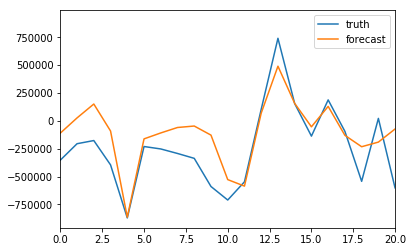

Month 3
Trained using month 3...
Validating against month 3
Truth_anom shape: (56320, 50)
Forecast_anom shape: (56320, 50)


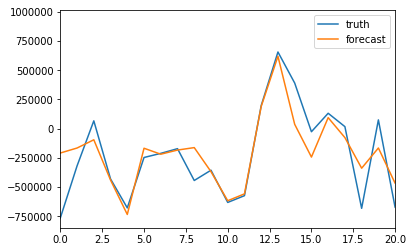

Month 4
Trained using month 4...
Validating against month 4
Truth_anom shape: (56320, 50)
Forecast_anom shape: (56320, 50)


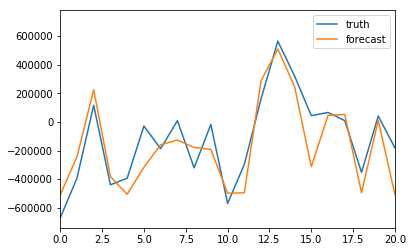

Month 5
Trained using month 5...
Validating against month 5
Truth_anom shape: (56320, 50)
Forecast_anom shape: (56320, 50)


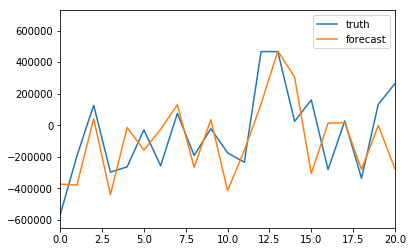

Month 6
Trained using month 6...
Validating against month 6
Truth_anom shape: (56320, 50)
Forecast_anom shape: (56320, 50)


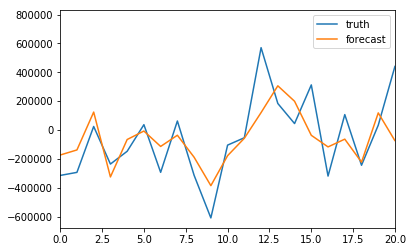

Month 7
Trained using month 7...
Validating against month 7
Truth_anom shape: (56320, 50)
Forecast_anom shape: (56320, 50)


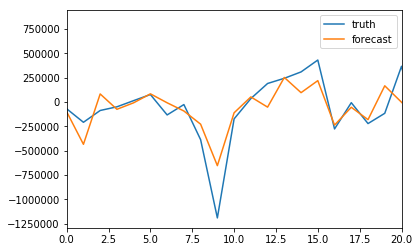

Month 8
Trained using month 8...
Validating against month 8
Truth_anom shape: (56320, 50)
Forecast_anom shape: (56320, 50)


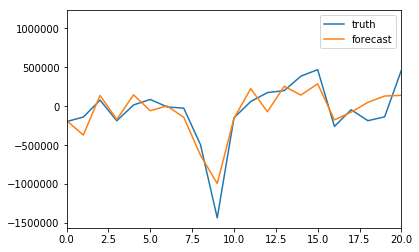

Month 9
Trained using month 9...
Validating against month 9
Truth_anom shape: (56320, 50)
Forecast_anom shape: (56320, 50)


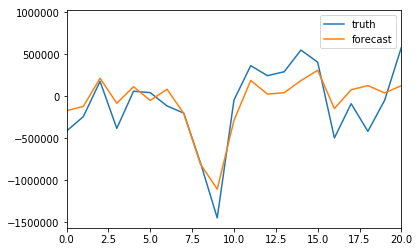

Month 10
Trained using month 10...
Validating against month 10
Truth_anom shape: (56320, 50)
Forecast_anom shape: (56320, 50)


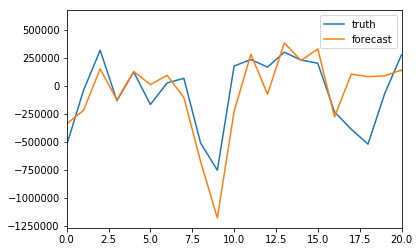

In [25]:
validvars = ['tas','tos','sit','sic']
months=[0,1,2,3,4,5,6,7,8,9,10]
lag=1
validation_stats = {}

for k, var in enumerate(validvars):
    valid_stats = {}
    v = {}
    X_var, _ = limkb.load_data(var, v, fdic_train, remove_climo=True, detrend=True, verbose=True)
    
    corr_tot = np.zeros((len(months)))
    ce_tot = np.zeros((len(months)))
    gm_var_ratio = np.zeros((len(months)))
    
    for i,m in enumerate(months):
        print('Month '+str(m))
        [truth_anom, forecast_anom] = limbuild.gather_truth_forecast_allmo(lag,var,m,X_var,
                                                                        x_forecast_dcomp_mo[:,:,:,m],
                                                                        var_dict,ntrain,insamp=Insamp)
        print('Truth_anom shape: '+str(truth_anom.shape))
        print('Forecast_anom shape: '+str(forecast_anom.shape))

        [corr_tot[i], ce_tot[i], gm_var_ratio[i], tot_var_forecast, 
         tot_var_truth] = limbuild.calc_validataion_stats(var, truth_anom, forecast_anom, var_dict,
                                                          areacell,areacell_dict,
                                                          areawt_name,month_names,iplot=True)
        
    valid_stats['corr_tot'] = corr_tot
    valid_stats['ce_tot'] = ce_tot
    valid_stats['gm_var_ratio'] = gm_var_ratio
    
    validation_stats[var] = valid_stats
    
    del X_var

In [44]:
validation_stats

{'tas': {'corr_tot': array([0.82057855, 0.70296785, 0.75385488, 0.75375319, 0.82824343,
         0.87404991, 0.87711547, 0.88734315, 0.90590414, 0.9057318 ,
         0.89966681]),
  'ce_tot': array([0.66955016, 0.48471932, 0.56539193, 0.55797215, 0.68571472,
         0.75938357, 0.76333345, 0.77315041, 0.80916657, 0.80817882,
         0.80767781]),
  'gm_var_ratio': array([1.04606866, 1.06380186, 1.07434795, 1.10489386, 1.1175148 ,
         1.08035031, 1.04997877, 1.06177067, 1.05985949, 1.03335873,
         1.01478325])},
 'tos': {'corr_tot': array([0.89219102, 0.85545585, 0.87932335, 0.87782885, 0.89142241,
         0.90196575, 0.89752865, 0.90735458, 0.92128368, 0.93615994,
         0.93480812]),
  'ce_tot': array([0.79554132, 0.73171517, 0.77298407, 0.76697441, 0.77989364,
         0.79359367, 0.79353583, 0.80463969, 0.83462428, 0.86863232,
         0.87311103]),
  'gm_var_ratio': array([1.21910425, 1.2426366 , 1.28307379, 1.23912643, 1.19961469,
         1.14448633, 1.13341825, 1.

In [26]:
for i,var in enumerate(validvars):
    print(var +': ' + str(np.mean(validation_stats[var]['corr_tot']**2)))

tas: 0.01388327680673025
tos: 0.07388127194422851
sit: 0.4916739385896237
sic: 0.6126363654415337


In [27]:
month_names = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov']

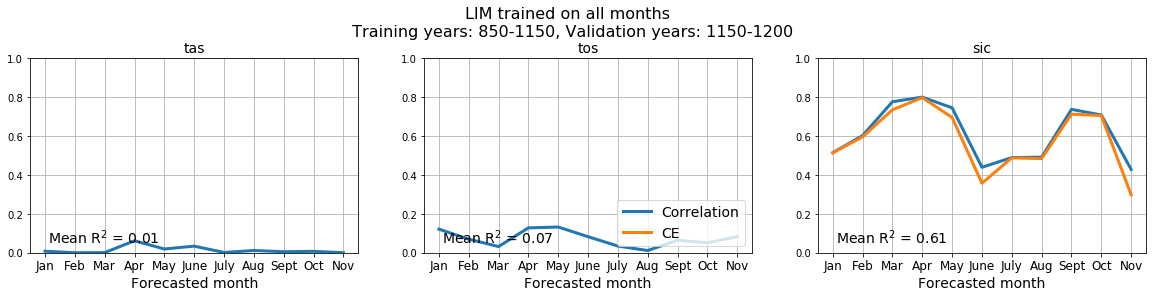

In [29]:
fig,axs = plt.subplots(1,3,figsize=(20,4))
#fig,axs= plt.subplots(2, 2)

ax = axs.flatten()

for i,var in enumerate(['tas','tos','sic']):
    ax[i].plot(validation_stats[var]['corr_tot']**2, label='Correlation',linewidth=3.0)
    ax[i].plot(validation_stats[var]['ce_tot'],label='CE',linewidth=3.0)

    ax[i].set_ylim(0,1)
#     ax[i].set_xlim(0,10)
    ax[i].set_xticks(np.arange(0,11,1))
    ax[i].set_xticklabels(month_names,fontsize=12)
    ax[i].grid(axis='both')
    ax[i].set_title(var, fontsize=14)
    ax[i].text(0.1,0.05, ("Mean R$^2$ = "+str(np.round(np.mean(validation_stats[var]['corr_tot']**2),2))),fontsize=14)
    
if Insamp==True:     
    plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
                 ', Validation years: '+str(850)+'-'+str(int(850+ntrain*1000))), fontsize=16)
else:     
    plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+
                  str(int(850+ntrain*1000))+', Validation years: '+
                  str(int(850+ntrain*1000))+'-'+str(int(850+ntrain*1000+nvalidtimes/12))), fontsize=16)

# ax[i].text(0.1,0.05, ("Training years: "+str(850)+'-'+str(850+ntrain*1000)),fontsize=14)
# ax[i].text(0.1,0.05, ("Validation years: "+str(850+ntrain*1000)+'-1850'),fontsize=14)


ax[1].legend(loc='lower right', fontsize=14)
ax[2].set_xlabel('Forecasted month', fontsize=14)
ax[1].set_xlabel('Forecasted month', fontsize=14)
ax[0].set_xlabel('Forecasted month', fontsize=14)

plt.subplots_adjust(top=0.8)

In [86]:
for i,var in enumerate(limvars):
    print(var +': ' + str(np.mean(validation_stats[var]['gm_var_ratio'])))

tas: 1.06424803064513
tos: 1.1769877572571301
sic: 0.7056019694356923


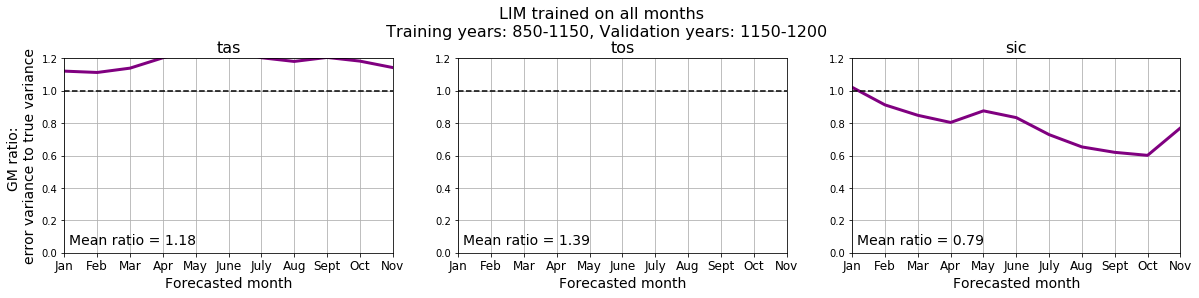

In [30]:
fig,axs = plt.subplots(1,3,figsize=(20,4))
#fig,axs= plt.subplots(2, 2)

ax = axs.flatten()

for i,var in enumerate(['tas','tos','sic']):
    ax[i].plot(validation_stats[var]['gm_var_ratio'],linewidth=3.0, color='purple')

#    ax[i].set_ylim(0,1)
    ax[i].set_xlim(0,10)
    ax[i].set_ylim(0,1.2)
    ax[i].set_xticks(np.arange(0,11,1))
    ax[i].set_xticklabels(month_names,fontsize=12)
    ax[i].grid(axis='both')
    ax[i].set_title(var, fontsize=16)
    ax[i].text(0.15,0.05, ("Mean ratio = "+str(np.round(np.mean(validation_stats[var]['gm_var_ratio']),2))),
               fontsize=14)
    ax[i].axhline(1.0,color='k',linestyle='--')

if Insamp==True:     
    plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
                 ', Validation years: '+str(850)+'-'+str(int(850+ntrain*1000))), fontsize=16)
else:     
    plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+
                  str(int(850+ntrain*1000))+', Validation years: '+
                  str(int(850+ntrain*1000))+'-'+str(int(850+ntrain*1000+nvalidtimes/12))), fontsize=16)
    
ax[2].set_xlabel('Forecasted month', fontsize=14)
ax[1].set_xlabel('Forecasted month', fontsize=14)
ax[0].set_xlabel('Forecasted month', fontsize=14)
ax[0].set_ylabel('GM ratio: \nerror variance to true variance', fontsize=14)

plt.subplots_adjust(top=0.8)

In [57]:
np.nanvar(truth_anom,axis=1,ddof=1).shape, truth_anom.shape

((56320,), (56320, 167))

In [78]:
np.nansum((truth_anom - np.nanmean(truth_anom,axis=1)[:,np.newaxis]),axis=1).shape

(56320,)

In [ ]:
plt.plot(x_var_dt[1061,:])
plt.plot(x_var[1061,:])

In [ ]:
error_sic_2d = np.reshape(error_var, (var_dict['sic']['lat'].shape))
plt.pcolormesh(error_sic_2d)
plt.colorbar()
plt.title('Error Variance: SIC')

In [ ]:
error_sic_2d = np.reshape(truth_error_var, (var_dict['sic']['lat'].shape))
plt.pcolormesh(error_sic_2d)
plt.colorbar()
plt.title('Truth Variance: SIC')

In [ ]:
x = np.array([1,3,2,5,9,11,13,2,6])
y = np.array([3,4,9,8,12,1,11,6,15])

In [ ]:
plt.plot(x)
plt.plot(y)

In [ ]:
np.var(x-y)

In [ ]:
np.sum((x-y)**2)